## Initial cuts

In [38]:
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
%matplotlib inline
path = '/Users/chris/Desktop/sculpting/berger_gaia_kepler/'
# all data downloaded from Berger et al 2020's ancillary tables: https://arxiv.org/src/2001.07737v3/anc
# the paper we're comparing against: https://arxiv.org/pdf/2005.14671.pdf
# command line edit to get rid of double backslashes at end of each row: sed -e "s/\\\//g" GKSPCPapTable2_Final.txt > GKSPCPapTable2_cleaned.txt
table2 = pd.read_csv(path+'GKSPCPapTable2_cleaned.txt', sep='&', header=0)
print(len(table2))
print(table2.head())
print(table2.columns)

186301
      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
0  757076     1.396          0.179         -0.218    5052.2          103.9   
1  757099     0.873          0.054         -0.039    5364.9          102.7   
2  757137     1.669          0.309         -0.300    4628.7           84.8   
3  757280     1.715          0.086         -0.089    6856.8          144.4   
4  757450     0.914          0.062         -0.057    5301.2          111.0   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...  iso_age  \
0          -86.6     3.373          0.067         -0.081  ...     2.47   
1          -84.9     4.318          0.037         -0.029  ...    15.20   
2          -76.2     2.388          0.083         -0.086  ...     1.51   
3         -139.9     3.834          0.033         -0.032  ...     1.24   
4         -103.1     4.432          0.045         -0.044  ...     9.46   

   unReAgeFlag  iso_age_err1  iso_age_err2  iso_dis  iso_dis_err1  \
0         

In [39]:
# remove stars with unreliable ages or bad goodness of fit
table2 = table2.loc[(table2.unReAgeFlag.isnull()) & (table2.iso_gof==1.)]
print(len(table2))

150560


In [40]:
# remove stars with uninformative posteriors (per paper, terminal age of main sequence > 20 Gyr)
table2 = table2.loc[table2['TAMS']<=20]
print(len(table2))
# nice to see that tracks with bad gof or unreliable age

150560


In [41]:
# remove stars beyond [3700, 7500] K Teff, ie. keep only FGK stars
fgk = table2.loc[(table2['iso_teff'] <= 7500) & (table2['iso_teff'] >= 3700)]
print(len(table2))

150560


In [42]:
# introduce Table 1 to use RUWE (re-normalized unit-weight error), aka binary star/edge-of-parameter space classifier
# command line edit to get rid of double backslashes at end of each row: sed -e "s/\\\//g" GKSPCPapTable1_Final.txt > GKSPCPapTable1_cleaned.txt
table1 = pd.read_csv(path+'GKSPCPapTable1_cleaned.txt', sep='&', header=0)
table1 = table1.loc[table1.RUWE<=1.2]
print(len(table1))
print(table1.head())
print(table1.columns)

164740
      KIC     gmag  gmag_err    kmag  kmag_err  parallax  parallax_err    feh  \
0  757076  12.3510    0.0203   9.559     0.017    1.5239        0.0483    NaN   
2  757137  10.0523    0.0279   6.722     0.017    1.7534        0.0253    NaN   
3  757280  12.1329    0.0200  10.627     0.018    1.2137        0.0220    NaN   
4  757450  15.8950    0.0202  13.118     0.029    1.1989        0.0261  0.229   
7  892010  12.6168    0.0209   9.041     0.017    0.5414        0.0242    NaN   

   feh_err    RUWE  num_gaia_companions Kmag_final_prov evstate  
0      NaN  0.9467                    0             NaN     NaN  
2      NaN  0.9126                    0             NaN     RGB  
3      NaN  0.8704                    0             NaN     NaN  
4     0.15  1.0300                    0             NaN     NaN  
7      NaN  1.0141                    0             NaN     NaN  
Index(['KIC', 'gmag', 'gmag_err', 'kmag', 'kmag_err', 'parallax',
       'parallax_err', 'feh', 'feh_err', 'RU

In [43]:
# join tables
catalog = pd.merge(fgk, table1, how='inner', on='KIC')
print(catalog.head())
print(len(catalog))

      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
0  757076     1.396          0.179         -0.218    5052.2          103.9   
1  757137     1.669          0.309         -0.300    4628.7           84.8   
2  757280     1.715          0.086         -0.089    6856.8          144.4   
3  757450     0.914          0.062         -0.057    5301.2          111.0   
4  892010     1.710          0.708         -0.402    4555.8          141.3   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...    kmag  \
0          -86.6     3.373          0.067         -0.081  ...   9.559   
1          -76.2     2.388          0.083         -0.086  ...   6.722   
2         -139.9     3.834          0.033         -0.032  ...  10.627   
3         -103.1     4.432          0.045         -0.044  ...  13.118   
4          -92.4     2.299          0.163         -0.119  ...   9.041   

   kmag_err  parallax  parallax_err    feh  feh_err    RUWE  \
0     0.017    1.5239        

In [44]:
# isolate giant stars
# using unnumbered equation in first paragraph of Sec 4.2.1 ("Sample Selection") in Berger et al 2020b 
catalog['logR'] = np.log10(catalog.iso_rad)
catalog['is_giant'] = np.where(catalog['logR'] >= 0.00035*(catalog['iso_teff'] - 4500) + 0.15, True, False)
catalog = catalog.loc[catalog['is_giant'] == False]
print(len(catalog))
print(catalog.head())

112397
      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
2  757280     1.715          0.086         -0.089    6856.8          144.4   
3  757450     0.914          0.062         -0.057    5301.2          111.0   
6  892195     0.862          0.057         -0.040    5333.4          101.3   
7  892667     1.548          0.081         -0.087    6704.9          148.8   
8  892675     1.038          0.066         -0.076    5929.4          108.9   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...  parallax  \
2         -139.9     3.834          0.033         -0.032  ...    1.2137   
3         -103.1     4.432          0.045         -0.044  ...    1.1989   
6          -84.2     4.372          0.039         -0.029  ...    2.0802   
7         -128.8     3.950          0.034         -0.036  ...    0.8512   
8         -108.1     4.385          0.035         -0.043  ...    1.7114   

   parallax_err    feh  feh_err    RUWE  num_gaia_companions  Kmag_final_

In [45]:
# get rid of stars with age errors greater than 1 Gyr
print(len(catalog))
catalog = catalog.loc[np.abs(catalog.iso_age_err1) < 1.]
catalog = catalog.loc[np.abs(catalog.iso_age_err2) < 1.]
print(len(catalog))

112397
19969


In [ ]:
"""# m dwarf side plot: what are error bounds for m dwarfs?
table2 = pd.read_csv(path+'GKSPCPapTable2_cleaned.txt', sep='&', header=0)
table2['logR'] = np.log10(table2.iso_rad)
table2['is_giant'] = np.where(table2['logR'] >= 0.00035*(table2['iso_teff'] - 4500) + 0.15, True, False)
table2 = table2.loc[table2.is_giant==False]
table2 = table2.loc[(table2['iso_teff'] <= 3700) & (table2['iso_teff'] >= 2400)]
print(len(table2))
print(table2.head())
print(np.mean(table2.iso_mass_err1))
print(np.mean(table2.iso_mass_err2))
print(np.mean(catalog.iso_mass_err1))
print(np.mean(catalog.iso_mass_err2))

print(np.mean(table2.iso_rad_err1))
print(np.mean(table2.iso_rad_err2))
print(np.mean(catalog.iso_rad_err1))
print(np.mean(catalog.iso_rad_err2))

print(np.mean(table2.iso_age_err1))
print(np.mean(table2.iso_age_err2))
print(np.mean(catalog.iso_age_err1))
print(np.mean(catalog.iso_age_err2))
"""

Berger et al star age distribution

[ 6807 17703 21082 18496 15373 12251 10255  8142  6336  4671  3437  2543
  1872  1339  1109   831   683   607   500   156]
[ 0.1   1.04  1.98  2.92  3.86  4.8   5.74  6.68  7.62  8.56  9.5  10.44
 11.38 12.32 13.26 14.2  15.14 16.08 17.02 17.96 18.9 ]


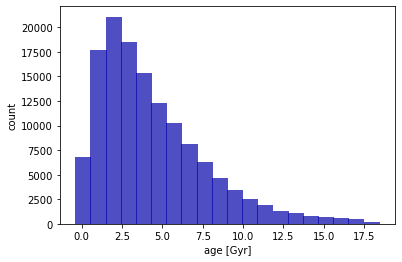

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline

# age histogram for all stars with well-constrained ages 
age_hist, age_bin_edges = np.histogram(catalog.iso_age, bins=20)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 1, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

In [34]:
# group by teff and plot median per group
teff_bins = np.linspace(catalog.iso_teff.min(), catalog.iso_teff.max(), 10) # create teff bins
teff_groups = catalog.iso_age.groupby(np.digitize(catalog.iso_teff, teff_bins)) # assign number to teff bins, then assign ages to bins
teff_groups.mean() # get mean of each bin


1     7.838221
2     8.263286
3     6.871056
4     4.888390
5     2.903208
6     1.884402
7     1.382486
8     1.136174
9     0.937718
10    0.900000
Name: iso_age, dtype: float64

[4879.6        5170.72222222 5461.84444444 5752.96666667 6044.08888889
 6335.21111111 6626.33333333 6917.45555556 7208.57777778 7499.7       ]
<PandasArray>
[ 7.838220858895704,  8.263285509325668,  6.871056322753293,
  4.888390123456809, 2.9032077201201765, 1.8844015317286669,
 1.3824858902001038, 1.1361744186046507, 0.9377183833116034,
                0.9]
Length: 10, dtype: float64


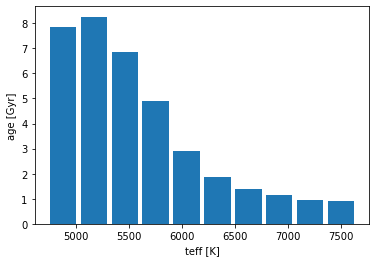

In [62]:
# plot mean age per teff bin for all stars with well-constrained ages
print(teff_bins)
print(teff_groups.mean().array)
plt.bar(teff_bins, teff_groups.mean().array, width=250)
plt.ylabel("age [Gyr]")
plt.xlabel("teff [K]")
plt.show()

In [63]:
# ratio of young stars to old
a = catalog.loc[catalog.iso_age < 1.0]
print(len(a))
print(len(catalog))
print(len(a)/len(catalog))

6340
134193
0.04724538537777678


## Cross-Matching with Kepler

In [90]:
# cross-matching from Megan Bedell's gaia-kepler.fun KIC objs
path = '/Users/chris/Desktop/sculpting/crossmatch_fun/'
hdu1 = fits.open(path+'kepler_dr2_1arcsec.fits')
data = hdu1[1].data
header = hdu1[1].header
columns = hdu1[1].columns
hdu1.close()

In [165]:
print(len(data[0]))
print(data[0])

134
(1635721458409799680, 'Gaia DR2 2050233807328471424', 2050233807328471424, 689405501, 2015.5, 291.03868130517526, 0.03587841951696976, 36.59803050177959, 0.04783193100319975, 1.4939158842221332, 0.04832756321407145, 30.912294, -4.960813153860173, 0.07927500542638122, -13.68268408787783, 0.08135066853388584, -0.035100333, 0.021850584, -0.03170967, -0.33841524, 0.5000767, -0.4209503, -0.23012185, -0.22412002, -0.15750915, -0.044099208, 105, 105, 100, 5, 2.0918074, 126.04239, 0.0, 0.0, 31, True, 611.1396, 1.5567976316779424, 0.011957889387888977, -0.27091637, 12, 10, 0.05254074, 0, 12, True, 93, 429068.4313471665, 130.7086417277348, 3282.6326, 11.607049, 12, 196805.46926130765, 360.63177916615274, 545.7241, 12.116295, 12, 329938.42846827576, 372.9979353685019, 884.55835, 10.9658375, 1.2276454, 0, 1.1504574, 0.5092459, 0.6412115, -16.281547099993276, 0.637275923583524, 6, 5000.0, 3.0, 0.0, 'NOT_AVAILABLE', 69.18255203341805, 9.799582973400991, 302.6196112374861, 57.67861553804456, 1000

In [166]:
print(len(columns))
print(columns)

134
ColDefs(
    name = 'solution_id'; format = 'K'; null = 999999
    name = 'designation'; format = '28A'
    name = 'source_id'; format = 'K'; null = 999999
    name = 'random_index'; format = 'K'; null = 999999
    name = 'gaia_ref_epoch'; format = 'D'
    name = 'ra'; format = 'D'; unit = 'deg'
    name = 'ra_error'; format = 'D'; unit = '10**-3 arcsec'
    name = 'dec'; format = 'D'; unit = 'deg'
    name = 'dec_error'; format = 'D'; unit = '10**-3 arcsec'
    name = 'parallax'; format = 'D'; unit = '10**-3 arcsec'
    name = 'parallax_error'; format = 'D'; unit = '10**-3 arcsec'
    name = 'parallax_over_error'; format = 'E'
    name = 'pmra'; format = 'D'; unit = '10**-3 arcsec yr-1'
    name = 'pmra_error'; format = 'D'; unit = '10**-3 arcsec yr-1'
    name = 'pmdec'; format = 'D'; unit = '10**-3 arcsec yr-1'
    name = 'pmdec_error'; format = 'D'; unit = '10**-3 arcsec yr-1'
    name = 'ra_dec_corr'; format = 'E'
    name = 'ra_parallax_corr'; format = 'E'
    name = 'ra_pmra

In [60]:
# enough noodling. let's read into pandas table
kep_data = Table.read(path+'kepler_dr2_1arcsec.fits', format='fits')
kep_data = kep_data.to_pandas()
# decode byte literal column to string
kep_data['planet?'] = kep_data['planet?'].str.decode("utf-8")
kep_data_thin = kep_data[['kepid','planet?']]
print(kep_data_thin.head())

    kepid planet?
0  757076    none
1  757099    none
2  757137    none
3  757280    none
4  757450    conf


In [61]:
# join Bedell cross-match with Berger catalog
crossmatch = pd.merge(catalog, kep_data, how='inner', left_on='KIC', right_on='kepid')
print(len(catalog))
print(len(kep_data))
print(len(crossmatch))
print(crossmatch.head())

19969
201312
19995
      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
0  757280     1.715          0.086         -0.089    6856.8          144.4   
1  892667     1.548          0.081         -0.087    6704.9          148.8   
2  892678     1.584          0.071         -0.062    5890.4          121.6   
3  892713     1.731          0.219         -0.087    6238.9          123.4   
4  892828     1.398          0.071         -0.069    6464.3          137.7   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...  mass_err2  \
0         -139.9     3.834          0.033         -0.032  ...     -0.157   
1         -128.8     3.950          0.034         -0.036  ...     -0.236   
2         -114.9     3.574          0.030         -0.030  ...     -0.204   
3         -129.8     3.548          0.066         -0.037  ...     -0.270   
4         -128.9     4.034          0.032         -0.034  ...     -0.217   

   prov_sec  nconfp  nkoi  ntce    jmag    hmag  kmag_y

Let's try it with 20" search radius

In [97]:
# cross-matching from Megan Bedell's gaia-kepler.fun KIC objs, 20 arcsec search radius
path = '/Users/chris/Desktop/sculpting/crossmatch_fun/'
kep20_data = Table.read(path+'kepler_dr2_20arcsec.fits', format='fits')
kep20_data = kep20_data.to_pandas()
# decode byte literal column to string
kep20_data['planet?'] = kep20_data['planet?'].str.decode("utf-8")
kep20_data_thin = kep20_data[['kepid','planet?']]
print(kep20_data.head())

           solution_id                      designation            source_id  \
0  1635721458409799680  b'Gaia DR2 2050233807328471424'  2050233807328471424   
1  1635721458409799680  b'Gaia DR2 2050233807328478592'  2050233807328478592   
2  1635721458409799680  b'Gaia DR2 2050233807334975360'  2050233807334975360   
3  1635721458409799680  b'Gaia DR2 2050233772971543424'  2050233772971543424   
4  1635721458409799680  b'Gaia DR2 2050233601170050048'  2050233601170050048   

   random_index  gaia_ref_epoch          ra  ra_error        dec  dec_error  \
0     689405501          2015.5  291.038681  0.035878  36.598031   0.047832   
1    1206779337          2015.5  291.039570  1.695041  36.599736   2.169884   
2    1356493136          2015.5  291.039085  0.144845  36.600585   0.169531   
3     522568337          2015.5  291.035938  8.851472  36.595820  20.159809   
4     658184587          2015.5  291.042819  1.921768  36.596640   3.215848   

   parallax  ...  mass_err2  prov_sec  nconf

In [170]:
print(len(kep20_data))

1274059


In [8]:
hdu4 = fits.open(path+'kepler_dr2_20arcsec.fits')
data = hdu4[1].data
header = hdu4[1].header
columns = hdu4[1].columns
hdu4.close()

In [11]:
print(len(columns))
print(columns)

134
ColDefs(
    name = 'solution_id'; format = 'K'; null = 999999
    name = 'designation'; format = '28A'
    name = 'source_id'; format = 'K'; null = 999999
    name = 'random_index'; format = 'K'; null = 999999
    name = 'gaia_ref_epoch'; format = 'D'
    name = 'ra'; format = 'D'; unit = 'deg'
    name = 'ra_error'; format = 'D'; unit = '10**-3 arcsec'
    name = 'dec'; format = 'D'; unit = 'deg'
    name = 'dec_error'; format = 'D'; unit = '10**-3 arcsec'
    name = 'parallax'; format = 'D'; unit = '10**-3 arcsec'
    name = 'parallax_error'; format = 'D'; unit = '10**-3 arcsec'
    name = 'parallax_over_error'; format = 'E'
    name = 'pmra'; format = 'D'; unit = '10**-3 arcsec yr-1'
    name = 'pmra_error'; format = 'D'; unit = '10**-3 arcsec yr-1'
    name = 'pmdec'; format = 'D'; unit = '10**-3 arcsec yr-1'
    name = 'pmdec_error'; format = 'D'; unit = '10**-3 arcsec yr-1'
    name = 'ra_dec_corr'; format = 'E'
    name = 'ra_parallax_corr'; format = 'E'
    name = 'ra_pmra

In [89]:
print(data[0])
print(data[1])

(1635721458409799680, 'Gaia DR2 2050233807328471424', 2050233807328471424, 689405501, 2015.5, 291.03868130517526, 0.03587841951696976, 36.59803050177959, 0.04783193100319975, 1.4939158842221332, 0.04832756321407145, 30.912294, -4.960813153860173, 0.07927500542638122, -13.68268408787783, 0.08135066853388584, -0.035100333, 0.021850584, -0.03170967, -0.33841524, 0.5000767, -0.4209503, -0.23012185, -0.22412002, -0.15750915, -0.044099208, 105, 105, 100, 5, 2.0918074, 126.04239, 0.0, 0.0, 31, True, 611.1396, 1.5567976316779424, 0.011957889387888977, -0.27091637, 12, 10, 0.05254074, 0, 12, True, 93, 429068.4313471665, 130.7086417277348, 3282.6326, 11.607049, 12, 196805.46926130765, 360.63177916615274, 545.7241, 12.116295, 12, 329938.42846827576, 372.9979353685019, 884.55835, 10.9658375, 1.2276454, 0, 1.1504574, 0.5092459, 0.6412115, -16.281547099993276, 0.637275923583524, 6, 5000.0, 3.0, 0.0, 'NOT_AVAILABLE', 69.18255203341805, 9.799582973400991, 302.6196112374861, 57.67861553804456, 100001, 

In [98]:
crossmatch20 = pd.merge(catalog, kep20_data_thin, how='inner', left_on='KIC', right_on='kepid')
print(len(catalog))
print(len(kep20_data_thin))
print(len(crossmatch20))
print(crossmatch20.head())

112397
1274059
717943
      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
0  757280     1.715          0.086         -0.089    6856.8          144.4   
1  757280     1.715          0.086         -0.089    6856.8          144.4   
2  757280     1.715          0.086         -0.089    6856.8          144.4   
3  757280     1.715          0.086         -0.089    6856.8          144.4   
4  757280     1.715          0.086         -0.089    6856.8          144.4   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...  feh  feh_err  \
0         -139.9     3.834          0.033         -0.032  ...  NaN      NaN   
1         -139.9     3.834          0.033         -0.032  ...  NaN      NaN   
2         -139.9     3.834          0.033         -0.032  ...  NaN      NaN   
3         -139.9     3.834          0.033         -0.032  ...  NaN      NaN   
4         -139.9     3.834          0.033         -0.032  ...  NaN      NaN   

     RUWE  num_gaia_companions  Km

What's the diff between 20" and 1" Kepler data? I only care about whether a given Kepler ID star has planets or not. As long as 20" has no planet-presence degeneracies per Kepler ID, I should be able to use the 1" data, right? Wrong.

In [134]:
# for 1" data, group by to remove duplicates; ignore count column, that's just so I have a dataframe rather than a dataframegroupby object
group1 = kep_data_thin.groupby(by=['kepid','planet?']).size().to_frame(name = 'count').reset_index()
print(len(kep_data_thin))
print(len(group1))
print(group1.head())

201312
197775
    kepid  planet?  count
0  757076  b'none'      1
1  757099  b'none'      1
2  757137  b'none'      1
3  757280  b'none'      1
4  757450  b'conf'      1


In [130]:
# then see if any kepids have more than one answer for 'planet?'; if so, which ones and how many?
group1['dupe?'] = group1.duplicated(subset=['kepid'])
group1_discrep = group1.loc[group1['dupe?']==True]
print(len(group1_discrep))
print(group1_discrep.head())

0
Empty DataFrame
Columns: [kepid, planet?, count, dupe?]
Index: []


In [131]:
# repeat for 20"
group20 = kep20_data_thin.groupby(by=['kepid','planet?']).size().to_frame(name = 'count').reset_index()
print(len(kep20_data_thin))
print(len(group20))
print(group20.head())

1274059
199962
    kepid  planet?  count
0  757076  b'none'      9
1  757099  b'none'      4
2  757137  b'none'      7
3  757280  b'none'      9
4  757450  b'conf'     12


In [133]:
# then see if any kepids have more than one answer for 'planet?'; if so, which ones and how many?
group20['dupe?'] = group20.duplicated(subset=['kepid'])
group20_discrep = group20.loc[group20['dupe?']==True]
print(len(group20_discrep))
print(group20_discrep.head())

0
Empty DataFrame
Columns: [kepid, planet?, count, dupe?]
Index: []


In [202]:
print(len(group1.kepid.unique()))
print(len(group20.kepid.unique()))

197775
199962


Checks out! No matter the search radius, Kepler IDs are guaranteed to have one to one correspondence with the 'planet?' field. But since there are more unique Kepler IDs in the 20", that's what we'll go with. Also, we double-check that this is the case not only with planet occurrence, but also Teff, mass, radius, etc.

In [15]:
# final duplicate test
test1 = kep20_data.groupby(by=['kepid','planet?','teff', 'mass', 'radius', 'feh', 'logg', 'source_id']).size().to_frame(name = 'count').reset_index()
test1['dupe?'] = test1.duplicated(subset=['kepid','planet?','teff', 'mass', 'radius', 'feh', 'logg', 'source_id'])
test1_discrep = test1.loc[test1['dupe?']==True]
print(len(test1_discrep))
print(test1_discrep.head())

0
Empty DataFrame
Columns: [kepid, planet?, teff, mass, radius, feh, logg, source_id, count, dupe?]
Index: []


More noodling below re: 1" vs 20" data given the same Kepler ID

In [93]:
catalog.loc[catalog.KIC==757280]

,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,iso_logg,iso_logg_err1,iso_logg_err2,...,parallax,parallax_err,feh,feh_err,RUWE,num_gaia_companions,Kmag_final_prov,evstate,logR,is_giant
2,757280,1.715,0.086,-0.089,6856.8,144.4,-139.9,3.834,0.033,-0.032,...,1.2137,0.022,NaN,NaN,0.8704,0,NaN,NaN,0.416641,False


In [101]:
kep_data.loc[kep_data.kepid==757280]

,solution_id,designation,source_id,random_index,gaia_ref_epoch,ra,ra_error,dec,dec_error,parallax,...,mass_err2,prov_sec,nconfp,nkoi,ntce,jmag,hmag,kmag,planet?,kepler_gaia_ang_dist
3,1635721458409799680,b'Gaia DR2 2050230611879323904',2050230611879323904,1253666653,2015.5,291.095373,0.016886,36.564903,0.022993,1.183652,...,-0.157,b'DSEP',0,0,0,10.852,10.662,10.627,b'none',0.11642


In [98]:
kep20_data.loc[kep20_data.kepid==757280]

,solution_id,designation,source_id,random_index,gaia_ref_epoch,ra,ra_error,dec,dec_error,parallax,...,mass_err2,prov_sec,nconfp,nkoi,ntce,jmag,hmag,kmag,planet?,kepler_gaia_ang_dist
20,1635721458409799680,b'Gaia DR2 2050230611879323904',2050230611879323904,1253666653,2015.5,291.095373,0.016886,36.564903,0.022993,1.183652,...,-0.157,b'DSEP',0,0,0,10.852,10.662,10.627,b'none',0.116420
21,1635721458409799680,b'Gaia DR2 2050230611874998528',2050230611874998528,85105427,2015.5,291.093190,0.346382,36.567752,0.401893,1.010494,...,-0.157,b'DSEP',0,0,0,10.852,10.662,10.627,b'none',12.021851
22,1635721458409799680,b'Gaia DR2 2050230504496061312',2050230504496061312,1008265920,2015.5,291.091180,0.174134,36.564045,0.208500,0.428608,...,-0.157,b'DSEP',0,0,0,10.852,10.662,10.627,b'none',12.623216
23,1635721458409799680,b'Gaia DR2 2050230405720896128',2050230405720896128,1074470470,2015.5,291.099735,0.349447,36.564556,0.578099,0.510245,...,-0.157,b'DSEP',0,0,0,10.852,10.662,10.627,b'none',12.675831
24,1635721458409799680,b'Gaia DR2 2050230405714459136',2050230405714459136,491313723,2015.5,291.101484,0.363924,36.563571,0.438461,0.361719,...,-0.157,b'DSEP',0,0,0,10.852,10.662,10.627,b'none',18.263271
25,1635721458409799680,b'Gaia DR2 2050230611879328000',2050230611879328000,873396955,2015.5,291.097767,0.357488,36.569619,0.393498,0.410948,...,-0.157,b'DSEP',0,0,0,10.852,10.662,10.627,b'none',18.284805
26,1635721458409799680,b'Gaia DR2 2050230401416841984',2050230401416841984,416805470,2015.5,291.101209,0.396481,36.566974,0.549698,-0.152930,...,-0.157,b'DSEP',0,0,0,10.852,10.662,10.627,b'none',18.298952
27,1635721458409799680,b'Gaia DR2 2050230302641675520',2050230302641675520,160119417,2015.5,291.096068,0.367204,36.559636,0.407929,0.047262,...,-0.157,b'DSEP',0,0,0,10.852,10.662,10.627,b'none',19.174344
28,1635721458409799680,b'Gaia DR2 2050230611874999168',2050230611874999168,301323689,2015.5,291.091381,0.764334,36.569174,0.793404,2.155078,...,-0.157,b'DSEP',0,0,0,10.852,10.662,10.627,b'none',19.221718


Well that was all a moot point. After talking with Megan Bedell, it looks like I should be using 1".

## Planet occurrence rate

In [113]:
# use 1" search radius Kepler data

# drop duplicates on KIC, which we can do because we guaranteed one-to-one matching of KIC and planet-occurrence status
group_crossmatch = crossmatch.drop_duplicates(['KIC'])
print(len(crossmatch))
print(len(group_crossmatch))

# count Kepler objects with each type of planet occurrence
none = group_crossmatch.loc[group_crossmatch['planet?'] == 'none']
cand = group_crossmatch.loc[group_crossmatch['planet?'] == 'cand']
conf = group_crossmatch.loc[group_crossmatch['planet?'] == 'conf']
print(len(none))
print(len(cand))
print(len(conf))

# cand and conf planet occurrence rates across FGK dwarfs from Berger et al 2020
print("candidates only: ", len(cand)/len(group_crossmatch))
print("confirmed only: ", len(conf)/len(group_crossmatch))
print("candidates and confirmed: ", (len(cand)+len(conf))/len(group_crossmatch))

112700
112324
107495
3749
1080
candidates only:  0.03337666037534276
confirmed only:  0.009615042199351874
candidates and confirmed:  0.04299170257469463


In [114]:
# merge Bedell's Kepler cross-match with all well-defined stars from Berger et al 2020's Gaia-Kepler catalog
crossmatch_all = pd.merge(table2, kep_data_thin, how='inner', left_on='KIC', right_on='kepid')
print(len(table2))
print(len(kep_data_thin))
print(len(crossmatch_all))
print(crossmatch_all.head())

150560
201312
152450
      KIC  iso_mass  iso_mass_err1  iso_mass_err2  iso_teff  iso_teff_err1  \
0  757076     1.396          0.179         -0.218    5052.2          103.9   
1  757099     0.873          0.054         -0.039    5364.9          102.7   
2  757137     1.669          0.309         -0.300    4628.7           84.8   
3  757280     1.715          0.086         -0.089    6856.8          144.4   
4  757450     0.914          0.062         -0.057    5301.2          111.0   

   iso_teff_err2  iso_logg  iso_logg_err1  iso_logg_err2  ...  iso_age_err1  \
0          -86.6     3.373          0.067         -0.081  ...          1.82   
1          -84.9     4.318          0.037         -0.029  ...          3.00   
2          -76.2     2.388          0.083         -0.086  ...          1.06   
3         -139.9     3.834          0.033         -0.032  ...          0.20   
4         -103.1     4.432          0.045         -0.044  ...          5.36   

   iso_age_err2  iso_dis  iso_dis_e

In [118]:
# drop duplicates as with FGK cross-match
group_crossmatch_all = crossmatch_all.drop_duplicates(['KIC'])
print(len(crossmatch_all))
print(len(group_crossmatch_all))

# count objects with each type of planet occurrence
none_all = group_crossmatch_all.loc[group_crossmatch_all['planet?'] == 'none']
cand_all = group_crossmatch_all.loc[group_crossmatch_all['planet?'] == 'cand']
conf_all = group_crossmatch_all.loc[group_crossmatch_all['planet?'] == 'conf']
print(len(none_all))
print(len(cand_all))
print(len(conf_all))

# cand and conf planet occurrence rates across all well-defined stars from Berger et al 2020's Kepler-Gaia catalog
print("candidates only: ", len(cand_all)/len(group_crossmatch_all))
print("confirmed only: ", len(conf_all)/len(group_crossmatch_all))
print("candidates and confirmed: ", (len(cand_all)+len(conf_all))/len(group_crossmatch_all))

152450
150445
144396
4853
1196
candidates only:  0.032257635680813586
confirmed only:  0.00794974907773605
candidates and confirmed:  0.04020738475854964


## Cross-Matching with K2

In [189]:
# cross-matching from Megan Bedell's gaia-kepler.fun confirmed exoplanets...well of course there won't be a KIC to match on
from astropy.io import fits
path = '/Users/chris/Desktop/sculpting/crossmatch_fun/'
hdu3 = fits.open(path+'k2_dr2_1arcsec.fits')
data = hdu3[1].data
header = hdu3[1].header
columns = hdu3[1].columns
hdu3.close()

In [74]:
print(len(columns))
print(columns)

195
ColDefs(
    name = 'solution_id'; format = 'K'; null = 999999
    name = 'designation'; format = '28A'
    name = 'source_id'; format = 'K'; null = 999999
    name = 'random_index'; format = 'K'; null = 999999
    name = 'gaia_ref_epoch'; format = 'D'
    name = 'ra'; format = 'D'; unit = 'deg'
    name = 'ra_error'; format = 'D'; unit = '10**-3 arcsec'
    name = 'dec'; format = 'D'; unit = 'deg'
    name = 'dec_error'; format = 'D'; unit = '10**-3 arcsec'
    name = 'parallax'; format = 'D'; unit = '10**-3 arcsec'
    name = 'parallax_error'; format = 'D'; unit = '10**-3 arcsec'
    name = 'parallax_over_error'; format = 'E'
    name = 'pmra'; format = 'D'; unit = '10**-3 arcsec yr-1'
    name = 'pmra_error'; format = 'D'; unit = '10**-3 arcsec yr-1'
    name = 'pmdec'; format = 'D'; unit = '10**-3 arcsec yr-1'
    name = 'pmdec_error'; format = 'D'; unit = '10**-3 arcsec yr-1'
    name = 'ra_dec_corr'; format = 'E'
    name = 'ra_parallax_corr'; format = 'E'
    name = 'ra_pmra

## Cross-Matching with confirmed exoplanets

In [190]:
# cross-matching from Megan Bedell's gaia-kepler.fun confirmed exoplanets...doesn't seem to have KIC to match on...
from astropy.io import fits
path = '/Users/chris/Desktop/sculpting/crossmatch_fun/'
hdu2 = fits.open(path+'exoplanets_dr2_1arcsec.fits')
data = hdu2[1].data
header = hdu2[1].header
columns = hdu2[1].columns
#kep_data = Table.read(path+'kepler_dr2_1arcsec.fits', format='fits')
#kep_data = kep_data.to_pandas()[['kepid','planet?']]
#print(kep_data.head())
hdu2.close()

In [68]:
data[0]

(1635721458409799680, 'Gaia DR2 3946945413106333696', 3946945413106333696, 221573267, 2015.5, 185.17877927819265, 0.16203243145904145, 17.79325163825353, 0.131687630347403, 10.710445335679449, 0.2197390136107608, 48.741665, -109.2413803041909, 0.3161072085232074, 88.17010164023338, 0.2772971016262472, -0.24134229, -0.33809444, 0.15142575, 0.13483438, -0.110146195, -0.016184712, 0.43014202, 0.005286964, -0.41975275, -0.3410357, 378, 378, 334, 44, 117.97339, 22105.432, 0.8913460033957228, 381.93167542286074, 31, True, 1.1513063, 1.7238976028274915, 0.03928369901084555, 0.06852711, 44, 11, 0.17436285, 0, 53, False, 411, 336024521.9139364, 860953.7315569692, 390.29337, 4.3724384, 40, 140928619.43828443, 279608.64519581286, 504.02097, 4.97889, 45, 244017880.46586746, 490175.345571102, 497.81754, 3.793366, 1.1455905, 0, 1.185524, 0.6064515, 0.5790725, 43.36898087333795, 0.20870222477915987, 16, 4750.0, 3.0, -0.25, 'NOT_AVAILABLE', 264.1377247628008, 78.2805843948228, 177.4217840787002, 18.33

In [69]:
print(len(columns))
columns

195


ColDefs(
    name = 'solution_id'; format = 'K'; null = 999999
    name = 'designation'; format = '28A'
    name = 'source_id'; format = 'K'; null = 999999
    name = 'random_index'; format = 'K'; null = 999999
    name = 'gaia_ref_epoch'; format = 'D'
    name = 'ra'; format = 'D'; unit = 'deg'
    name = 'ra_error'; format = 'D'; unit = '10**-3 arcsec'
    name = 'dec'; format = 'D'; unit = 'deg'
    name = 'dec_error'; format = 'D'; unit = '10**-3 arcsec'
    name = 'parallax'; format = 'D'; unit = '10**-3 arcsec'
    name = 'parallax_error'; format = 'D'; unit = '10**-3 arcsec'
    name = 'parallax_over_error'; format = 'E'
    name = 'pmra'; format = 'D'; unit = '10**-3 arcsec yr-1'
    name = 'pmra_error'; format = 'D'; unit = '10**-3 arcsec yr-1'
    name = 'pmdec'; format = 'D'; unit = '10**-3 arcsec yr-1'
    name = 'pmdec_error'; format = 'D'; unit = '10**-3 arcsec yr-1'
    name = 'ra_dec_corr'; format = 'E'
    name = 'ra_parallax_corr'; format = 'E'
    name = 'ra_pmra_cor

## Joining confirmed exoplanets with Kepler cross-match

Pro: confirmed exoplanets dataset from gaia-kepler.fun has planet counts. Con: there's no KIC or kepid to join on.

In [62]:
import warnings
warnings.filterwarnings('ignore')
path = '/Users/chris/Desktop/sculpting/crossmatch_fun/'
confirmed = Table.read(path+'exoplanets_dr2_1arcsec.fits', format='fits')
confirmed = confirmed.to_pandas()
print(confirmed.head())

           solution_id                      designation            source_id  \
0  1635721458409799680  b'Gaia DR2 3946945413106333696'  3946945413106333696   
1  1635721458409799680  b'Gaia DR2 1696798367260229376'  1696798367260229376   
2  1635721458409799680  b'Gaia DR2 1920113512486282240'  1920113512486282240   
3  1635721458409799680  b'Gaia DR2 1385293808145621504'  1385293808145621504   
4  1635721458409799680  b'Gaia DR2 2135550755683407232'  2135550755683407232   

   random_index  gaia_ref_epoch          ra  ra_error        dec  dec_error  \
0     221573267          2015.5  185.178779  0.162032  17.793252   0.131688   
1      91495763          2015.5  229.274595  0.122354  71.823943   0.110681   
2     162105136          2015.5  352.824150  0.106518  39.235837   0.074691   
3    1155875906          2015.5  242.602101  0.019262  43.816362   0.019824   
4     166057510          2015.5  295.465642  0.022583  50.516824   0.024786   

    parallax  ...  pl_cbflag  pl_disc       

In [63]:
confirmed_kepler = pd.merge(confirmed, kep_data, how='inner', on='source_id')
print(len(confirmed))
print(len(kep_data))
print(len(confirmed_kepler))
print(confirmed_kepler.head())
print(confirmed_kepler.columns)

3666
201312
2367
         solution_id_x                    designation_x            source_id  \
0  1635721458409799680  b'Gaia DR2 2135550755683407232'  2135550755683407232   
1  1635721458409799680  b'Gaia DR2 2080063931448749824'  2080063931448749824   
2  1635721458409799680  b'Gaia DR2 2086512227851023872'  2086512227851023872   
3  1635721458409799680  b'Gaia DR2 2086512227851023872'  2086512227851023872   
4  1635721458409799680  b'Gaia DR2 2129256395211984000'  2129256395211984000   

   random_index_x  gaia_ref_epoch_x        ra_x  ra_error_x      dec_x  \
0       166057510            2015.5  295.465642    0.022583  50.516824   
1       712882192            2015.5  294.635917    0.034723  46.066408   
2      1678330809            2015.5  297.710176    0.019271  48.081864   
3      1678330809            2015.5  297.710176    0.019271  48.081864   
4        87789293            2015.5  292.247190    0.017649  47.969543   

   dec_error_x  parallax_x  ...  mass_err2  prov_sec  nco

In [64]:
# check that these are indeed the same star...it's really hard to tell
print(confirmed_kepler[['st_mass', 'mass', 'st_teff', 'teff', 'st_rad',
                        'radius', 'ra_x', 'ra_y', 'dec_x', 'dec_y', 'pl_pnum']].head(n=20))
# 'st_metfe', 'gmag', 'st_optmag', 'kmag',

    st_mass   mass  st_teff   teff  st_rad  radius        ra_x        ra_y  \
0      1.08  0.952   5750.0   5745    1.13   1.069  295.465642  295.465642   
1      0.48  3.244      NaN  10899     NaN   3.746  294.635917  294.635917   
2      0.81  0.830   4780.0   4778    0.68   0.763  297.710176  297.710176   
3      0.81  0.830   4780.0   4778    0.68   0.763  297.710176  297.710176   
4      1.56  1.449   6389.0   6440    2.00   1.952  292.247190  292.247190   
5      1.40  1.406   6453.0   6469    1.51   1.467  286.685473  286.685473   
6      0.90  0.938   5491.0   5741    0.88   0.846  286.273915  286.273915   
7      1.22  1.275   6144.0   6180    1.57   1.603  293.079463  293.079463   
8      1.11  0.931   6109.0   6068    1.17   0.831  292.020435  292.020435   
9      1.11  1.441   4972.0   4994    3.39   3.818  297.359343  297.359343   
10     1.00  0.946   5782.0   5727    1.06   1.104  286.285900  286.285900   
11     0.78  1.064   5328.0   6327    0.74   1.175  295.754207  

## CDPP

Characterize the noise between young and old stars with multiple CDPPs. Data from http://archive.stsci.edu/pub/kepler/catalogs/

In [46]:
path = '/Users/chris/Desktop/sculpting/crossmatch_fun/'
kepler_stellar = pd.read_csv(path+'kepler_stellar_17.csv')
print(len(kepler_stellar))
print(kepler_stellar.head())

200038
    kepid           tm_designation  teff  teff_err1  teff_err2   logg  \
0  757076  2MASS J19240929+3635532  5160      171.0     -156.0  3.580   
1  757099  2MASS J19241033+3635377  5519      182.0     -149.0  3.822   
2  757137  2MASS J19241341+3633358  4706       74.0     -102.0  2.374   
3  757280  2MASS J19242289+3633538  6543      162.0     -194.0  4.082   
4  757450  2MASS J19243302+3634385  5332      106.0      -96.0  4.500   

   logg_err1  logg_err2   feh  feh_err1  ...  timeout06p0  timeout07p5  \
0      0.928     -0.232 -0.10      0.30  ...          0.0          0.0   
1      0.638     -0.213 -0.22      0.35  ...          1.0          1.0   
2      0.030     -0.027 -0.10      0.20  ...          1.0          1.0   
3      0.258     -0.172 -0.24      0.25  ...          0.0          0.0   
4      0.050     -0.036 -0.08      0.15  ...          0.0          0.0   

   timeout09p0  timeout10p5  timeout12p0  timeout12p5  timeout15p0  \
0          0.0          0.0          0.

In [47]:
# join kepler_stellar table with post-FGK'd Berger tables (catalog) since we're only interested in those stars
kepler_stellar_enriched = pd.merge(kepler_stellar, catalog, how='inner', left_on='kepid', right_on='KIC')
print(len(kepler_stellar_enriched))
print(len(kepler_stellar))
print(len(catalog))
# looks like every single KIC in catalog has a match in kepler_stellar. That's a good sign. 

19969
200038
19969


In [ ]:
# get rid of stars with more than 1 Gyr age error
kepler_stellar_enriched = kepler_stellar_enriched.loc[kepler_stellar_enriched.iso_age_err1]

In [48]:
# divide between young and old stars
young = kepler_stellar_enriched.loc[kepler_stellar_enriched.iso_age <= 1.0]
old = kepler_stellar_enriched.loc[kepler_stellar_enriched.iso_age > 1.0]

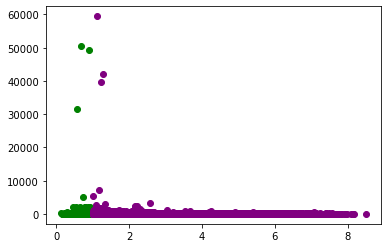

In [49]:
# plot to compare CDPPs of young vs old stars
plt.scatter(young.iso_age, young.rrmscdpp01p5, color='green')
plt.scatter(old.iso_age, old.rrmscdpp01p5, color='purple')
plt.show()

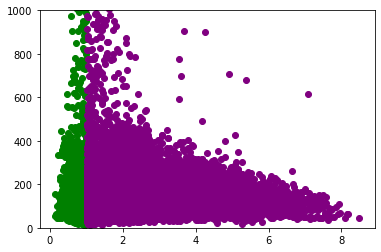

In [50]:
# plot to compare CDPPs of young vs old stars, zoomed in
plt.scatter(young.iso_age, young.rrmscdpp01p5, color='green')
plt.scatter(old.iso_age, old.rrmscdpp01p5, color='purple')
plt.ylim(0, 1000)
plt.show()

Let's try with CDPP of 3.0

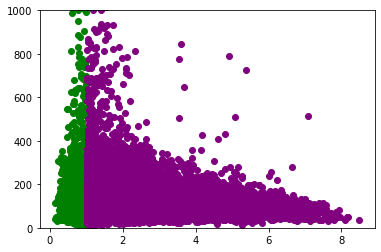

In [51]:
# plot to compare CDPPs of young vs old stars
plt.scatter(young.iso_age, young.rrmscdpp03p0, color='green')
plt.scatter(old.iso_age, old.rrmscdpp03p0, color='purple')
plt.ylim(0, 1000)
plt.show()

In [54]:
# maybe if I sampled fewer points (every 50th point), I can discern some structure...
step = 50
young_sample_age = young.iso_age[1::step]
old_sample_age = old.iso_age[1::step]
young_sample_cdpp = young.rrmscdpp03p0[1::step]
old_sample_cdpp = old.rrmscdpp03p0[1::step]

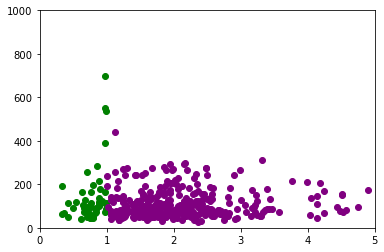

In [55]:
# well...maaaaybe there's something here?
plt.scatter(young_sample_age, young_sample_cdpp, color='green')
plt.scatter(old_sample_age, old_sample_cdpp, color='purple')
plt.ylim(0, 1000)
plt.xlim(0,5)
plt.show()

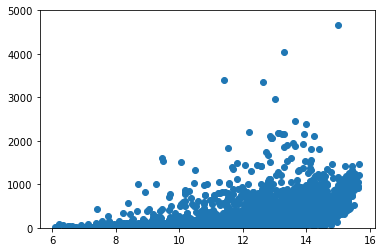

In [36]:
# sanity check, plotting magnitude vs cdpp (even if age has no clear correlation with noise, surely magnitude does)
plt.scatter(kepler_stellar_enriched.jmag, kepler_stellar_enriched.rrmscdpp03p0)
plt.ylim(0, 5000)
#plt.xlim(0,5)
plt.show()

To get S/N like Fig 9 in Berger et al 2020b, I need radius of planets, which means I now need to join the confirmed_kepler crossmatch joined table with the kepler_stellar_enriched joined table. 

In [65]:
# okay, really dumb name choice for what's guaranteed to be my smallest table
big = pd.merge(confirmed_kepler, kepler_stellar_enriched, how='inner', on='kepid')
print(len(big))

161


0      1.615864
1      0.076836
2      0.082279
3      0.107973
4      0.251078
         ...   
156    1.857881
157    0.031885
158    0.201898
159    1.375758
160    0.466146
Name: snr_1p5, Length: 161, dtype: float64


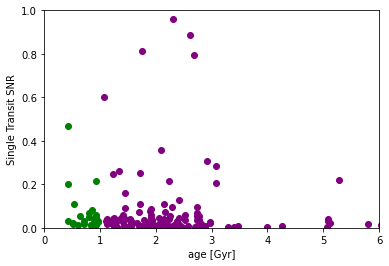

In [66]:
# plot to compare S/Ns of young vs old stars, using equation B2 from Petigura et al 2018
# S/N = ((r_p[Earth_radii]/r_s)**2)/cdpp

big['earth_radii'] = big['pl_radj']*11.2089 # but first pl_radj is in Jupiter radii, so convert to Earth radii 
big['snr_1p5'] = ((big['earth_radii']/big['iso_rad'])**2)/big['rrmscdpp01p5'] # re-factor as function later
print(big['snr_1p5']) # looks about right

# jeez, I'm really running my code in a suboptimal order and creating single-use dataframes
big_young = big.loc[big.iso_age <= 1.0]
big_old = big.loc[big.iso_age > 1.0]

plt.scatter(big_young.iso_age, big_young['snr_1p5'], color='green')
plt.scatter(big_old.iso_age, big_old['snr_1p5'], color='purple')
plt.ylim(0,1)
plt.xlim(0,6)
plt.ylabel('Single Transit SNR')
plt.xlabel('age [Gyr]')
plt.show()

In [67]:
print(len(big_young), len(big_old))

25 136


0      1.804977
1      0.086874
2      0.088950
3      0.141551
4      0.329160
         ...   
156    1.581064
157    0.039242
158    0.248477
159    1.693154
160    0.573688
Name: snr_3p0, Length: 161, dtype: float64


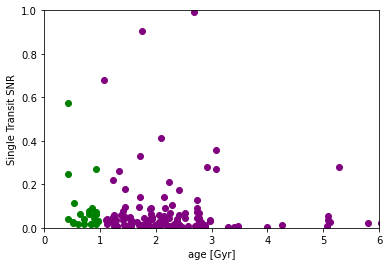

In [68]:
# and again for 3.0 CDPP
big['earth_radii'] = big['pl_radj']*11.2089 # but first pl_radj is in Jupiter radii, so convert to Earth radii 
big['snr_3p0'] = ((big['earth_radii']/big['iso_rad'])**2)/big['rrmscdpp03p0'] # re-factor as function later
print(big['snr_3p0']) # looks about right

# jeez, I'm really running my code in a suboptimal order and creating single-use dataframes
big_young = big.loc[big.iso_age <= 1.0]
big_old = big.loc[big.iso_age > 1.0]

plt.scatter(big_young.iso_age, big_young['snr_3p0'], color='green')
plt.scatter(big_old.iso_age, big_old['snr_3p0'], color='purple')
plt.ylim(0,1)
plt.xlim(0,6)
plt.ylabel('Single Transit SNR')
plt.xlabel('age [Gyr]')
plt.show()

CDPP histograms

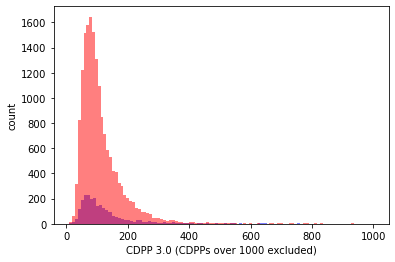

In [81]:
# chop off reallllly long tail
young_cdpp = young.loc[(young.rrmscdpp03p0>0) & (young.rrmscdpp03p0<1000)]
old_cdpp = old.loc[(old.rrmscdpp03p0>0) & (old.rrmscdpp03p0<1000)]

x1 = young_cdpp.rrmscdpp03p0
n1, bins1, patches1 = plt.hist(x1, 100, facecolor='blue', alpha=0.5)

x2 = old_cdpp.rrmscdpp03p0
n2, bins2, patches2 = plt.hist(x2, 100, facecolor='red', alpha=0.5)

plt.xlabel('CDPP 3.0 (CDPPs over 1000 excluded)')
plt.ylabel('count')
plt.show()

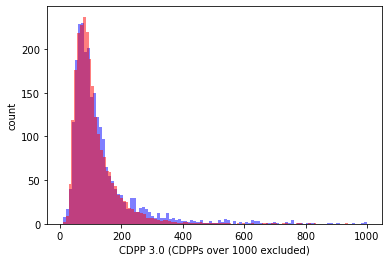

In [82]:
# scale old counts down to be proportional with young counts
n1, bins1, patches1 = plt.hist(x1, 100, facecolor='blue', alpha=0.5)
n2, bins2, patches2 = plt.hist(x2, 100, facecolor='red', alpha=0.5, weights=np.ones(len(x2))*(len(young)/len(old)))
plt.xlabel('CDPP 3.0 (CDPPs over 1000 excluded)')
plt.ylabel('count')
plt.show()


Okay that's cool but I don't want to be a dirty frequentist when determining whether my old and young star samples come from the same population in noise space. So let's introduce Farhan Feroz's MULTINEST algorithm for multimodal nested sampling.

In [83]:
mean_young = np.mean(x1)
mean_old = np.mean(x2)
std_young = np.std(x1)
std_old = np.std(x2)
print(mean_young, std_young, mean_old, std_old)

def gaussian_prob(sigma, chi_squared):
    return (1./np.sqrt(2*np.pi*sigma**2))*np.exp(-0.5*chi_squared)

def chi_squared(y, mean, sigma):
    term = ((y-mean)**2)/sigma
    return np.sum(term)

chi_squared_young = chi_squared(x1, mean_young, std_young)
chi_squared_old = chi_squared(x2, mean_old, std_old)
gaussian_prob_young = gaussian_prob(std_young, chi_squared_young)
gaussian_prob_old = gaussian_prob(std_old, chi_squared_old)
print(chi_squared_young, chi_squared_old, gaussian_prob_young, gaussian_prob_old)


132.78719408427855 115.4821346259947 113.95542440611003 80.4048510754472
285009.90825695463 1384330.3209659827 0.0 0.0


Well, maybe it's just because my data is not Gaussian, but clearly I can't proceed further in characterizing the likelihood of old vs young samples without better selection of model (Gaussian) or parameters (y_bar and sigma).

### See 'synthetic' notebook for the next part of this project.

All we'll do for the rest of this notebook is list out the age distribution for the 20K FGK dwarfs with age error <1 Gyr in preparation for generating a synthetic sample.

[ 409 1918 2978 3679 3709 2930 1248  638  469  431  369  348  290  211
  153   85   53   38    9    4]
[0.14   0.5575 0.975  1.3925 1.81   2.2275 2.645  3.0625 3.48   3.8975
 4.315  4.7325 5.15   5.5675 5.985  6.4025 6.82   7.2375 7.655  8.0725
 8.49  ]


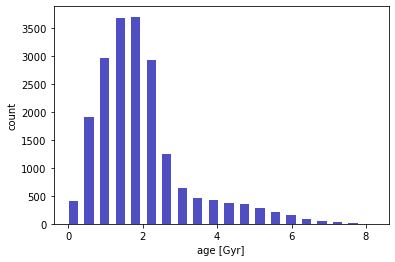

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

# age histogram for all stars with well-constrained ages (catalog was a merge with table2, not fgk)
age_hist, age_bin_edges = np.histogram(catalog.iso_age, bins=20)
print(age_hist)
print(age_bin_edges)
plt.bar(age_bin_edges[:-1], age_hist, width = 0.25, color='#0504aa',alpha=0.7)
plt.ylabel("count")
plt.xlabel("age [Gyr]")
plt.show()

In [88]:
kepler_stellar_enriched.to_csv('berger_kepler_stellar17.csv',index=False)